In [25]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

## This file demonstrates how to use Finite element method（FEM）solving 1D possion equation. 


/home/yanjun/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Define equations and boundary 

In [4]:
# fro equation -(xu')'=5-4x ,x in (2,4)
xmin = 2
xmax = 4

# boundary condition
g = [3,5]
kappa = [0,0]
N = 2

# function K is
def k(x):
    y = x
    return y

# function p is
def p(x):
    y = 0 * x
    return y

# function f is
def f(x):
    y = 5 - 4 * x
    return y

## 2. Mesh

In [5]:
def mesh1D(xmin,xmax,N):
    dx = (xmax - xmin) / N
    
    Th = [];
    ## construct a mesh Th for a one dimensional domain [xl,xR] with N+1 points
    for i in range(1,N+2):
        Th.append(((xmin +(i-1) * dx)))
        
    return Th


## another way for the loop:
     #Th = [x_min + (i-1) * dx for i in range(1, N+2)]   
    
## here use round because of the floating-point precusion issue

In [6]:
## verify the mesh function, will possible encounter floating-point precision issue

calculated = mesh1D(0,1,16)
expected = [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]
assert calculated == expected, f'{calculated=} != {expected=}'


In [7]:
mesh1 = mesh1D(0,1,4)
print(mesh1)

[0.0, 0.25, 0.5, 0.75, 1.0]


## 3. Matrixs assembler

In [8]:
def StiffnessAssembler1D(Th,k):
    import numpy as np
    n = len(Th)-1
    A = np.zeros((n+1,n+1))
    
    for i in range(n):
        h = Th[i+1] -Th[i]
        xmid = (Th[i+1] + Th[i]) / 2
    
        A[i,i] = A [i,i] + k(xmid) / h
        A[i,i+1] = A[i,i+1] -k(xmid) / h
        A[i+1,i] = A[i+1,i] -k(xmid) / h
        A[i+1,i+1] = A[i+1,i+1]+ k(xmid) / h
    
    # first row
    A[0,0] = 1
    A[0,1] = 0
    
    # last row
    A[n,n] = 1 
    A[n,n-1] = 0
    
    return A
   

In [9]:
mesh1 = mesh1D(0,1,8)
c = StiffnessAssembler1D(mesh1, k)
print (c)

[[ 1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.5  2.  -1.5  0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.5  4.  -2.5  0.   0.   0.   0.   0. ]
 [ 0.   0.  -2.5  6.  -3.5  0.   0.   0.   0. ]
 [ 0.   0.   0.  -3.5  8.  -4.5  0.   0.   0. ]
 [ 0.   0.   0.   0.  -4.5 10.  -5.5  0.   0. ]
 [ 0.   0.   0.   0.   0.  -5.5 12.  -6.5  0. ]
 [ 0.   0.   0.   0.   0.   0.  -6.5 14.  -7.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1. ]]


In [24]:
print(type(c))

<class 'numpy.ndarray'>


In [10]:
calculated = StiffnessAssembler1D(mesh1D(0,1,2),k)
expected = np.array(
[[ 1, 0, 0 ],
 [-0.5, 2, -1.5],
 [ 0,  0,  1]]
)
assert np.all(calculated == expected), f'{calculated=} != {expected=}'

## here need to use np.all since there are two matrixs two compare
## it checks all elements in the boolen array

In [11]:
def MassAssembler1D(Th,p):
    import numpy as np
    n = len(Th)-1
    M = np.zeros((n+1,n+1))
    
    for i in range(n):
        xmid = (Th[i+1] + Th[i]) / 2
        pmid = p(xmid)    
        h = Th[i+1] -Th[i]
        
        M[i-1, i-1] = M[i-1, i-1] + pmid/ h
        M[i-1, i] = M[i-1, i] - pmid/h
        M[i, i-1] = M[i, i-1] - pmid/h
        M[i, i] = M[i, i] + pmid/h
        
    M[0, 0] = 0
    M[0, 1] = 0
    M[n, n] = 0
    M[n, 1-1] = 0
    
    return M

In [12]:
def LoadAssembler1D(Th,f,g):
    import numpy as np
    n = len(Th)-1
    b = np.zeros((n+1,1))
    
    for i in range(n):
        h = Th[i+1] -Th[i]
        
        # add h/2 to b(i)
        b[i] = b[i] + f(Th[i]) * h / 2; 
        
        # add h/2 to b(i,i)
        b[i+1]= b[i+1] + f(Th[i+1]) * h / 2; 
        
    b[0] = g[0]
    b[n] = g[1]
    
    return b      


In [13]:
calculated = LoadAssembler1D(mesh1D(0,1,4),f,g)
expected = np.array(
[[ 3 ], [1],[ 0.75 ],[ 0.5 ], [ 5]])

assert np.all(calculated == expected), f'{calculated=} != {expected=}'

In [14]:
load = LoadAssembler1D(mesh1D(0,1,4),f,g)
print(load)

[[3.  ]
 [1.  ]
 [0.75]
 [0.5 ]
 [5.  ]]


## 4. Solve

In [15]:
def solve1D(xmin,xmax,N,k,f, g):
    Th = mesh1D(xmin,xmax,N);
    A = StiffnessAssembler1D (Th, k)
    M = MassAssembler1D(Th, p)
    b = LoadAssembler1D(Th, f, g)
    uh = np.linalg.solve(A, b)
    
    return uh

uh = solve1D(xmin,xmax,N,k,f, g)
#print (uh)

uh8 = solve1D(xmin,xmax,8,k,f, g)
print(uh8)
Th8 = mesh1D(xmin,xmax,8)

[[3.    ]
 [2.8125]
 [2.75  ]
 [2.8125]
 [3.    ]
 [3.3125]
 [3.75  ]
 [4.3125]
 [5.    ]]


In [16]:
Th = mesh1D(xmin,xmax,8)
print(f"1: mesh or x is \n{Th}")
print()
#print(f"2: Stiffness matrix is \n{A}")
print()
b = LoadAssembler1D(Th, f, g)
print(f"3: Load vector is \n{b}")


1: mesh or x is 
[2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]


3: Load vector is 
[[ 3.  ]
 [-1.  ]
 [-1.25]
 [-1.5 ]
 [-1.75]
 [-2.  ]
 [-2.25]
 [-2.5 ]
 [ 5.  ]]


## 5. Error analysis

In [17]:
## u_ex1 is a list since Th
Th = mesh1D(xmin,xmax,N)
u_ex1 = [x**2 - 5*x + 9 for x in Th]
# print ('origin is',u_ex1)

## change list to array
u_ex2 = np.array(u_ex1)
#print('np.array is',u_ex2)

u_ex = u_ex2.reshape(-1,1)
#print('reshape is \n',u_ex)
#print(uh)
error = uh - u_ex
print(error)

[[0.]
 [0.]
 [0.]]


## 5. Plot

In [18]:
## for plotring 
Th1 = mesh1D(xmin,xmax,100);
u_ex1 = [x**2 - 5*x + 9 for x in Th1]
u_ex2 = np.array(u_ex1)
u_ex = u_ex2.reshape(-1,1)


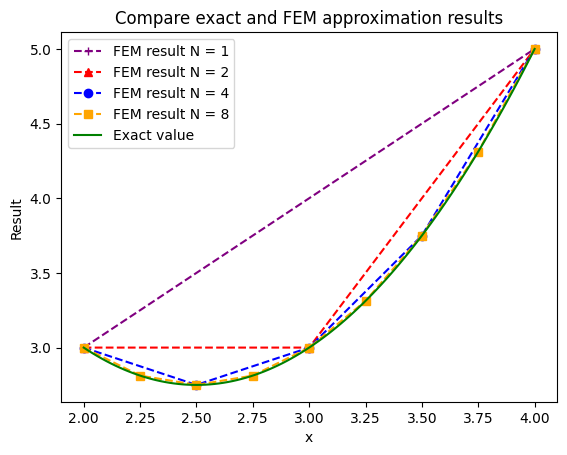

In [19]:
plt.plot(mesh1D(xmin,xmax,1),solve1D(xmin,xmax,1,k,f, g), marker ='+', label = 'FEM result N = 1', linestyle='--', color ='purple')
plt.plot(mesh1D(xmin,xmax,2),solve1D(xmin,xmax,2,k,f, g), marker ='^', label = 'FEM result N = 2', linestyle='--', color ='red')
plt.plot(mesh1D(xmin,xmax,4),solve1D(xmin,xmax,4,k,f, g), marker ='o', label = 'FEM result N = 4', linestyle='--', color ='blue')
plt.plot(mesh1D(xmin,xmax,8),solve1D(xmin,xmax,8,k,f, g), marker ='s', label = 'FEM result N = 8', linestyle='--', color ='orange')
#plt.plot(Th8,uh8,'y',label = 'FEM result N = 8')
plt.plot(Th1, u_ex, 'g', label = 'Exact value')
plt.title('Compare exact and FEM approximation results')
plt.xlabel('x')
plt.ylabel('Result')
plt.legend()

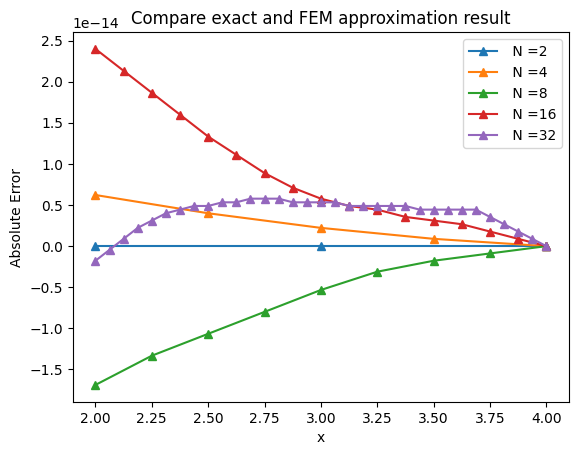

In [20]:
error = []
for i in range(5):
    N = 2**(i+1)
    #print(N)
    uh = solve1D(xmin,xmax,N,k,f, g)
    Th = mesh1D(xmin,xmax,N)
    u_ex1 = [x**2 - 5*x + 9 for x in Th]
    u_ex2 = np.array(u_ex1)
    u_ex = u_ex2.reshape(-1,1)
    
    error  =  u_ex - uh
   
    plt.plot(Th,error,marker = '^',label = f" N ={N}")
    plt.title('Compare exact and FEM approximation result')
    plt.xlabel('x')
    plt.ylabel('Absolute Error')
    plt.legend()

## Machine precision


In [22]:
import numpy as np
a = 1
while 1 < np.float32(1 + a):  ## check with single precision
    print(1+a)
    a *= 0.5
    
(f"The computer single precision is {2*a}")

2
1.5
1.25
1.125
1.0625
1.03125
1.015625
1.0078125
1.00390625
1.001953125
1.0009765625
1.00048828125
1.000244140625
1.0001220703125
1.00006103515625
1.000030517578125
1.0000152587890625
1.0000076293945312
1.0000038146972656
1.0000019073486328
1.0000009536743164
1.0000004768371582
1.000000238418579
1.0000001192092896


'The computer single precision is 1.1920928955078125e-07'

In [23]:
import numpy as np
a = 1
while 1 < (1 + a):  ## check with double precision
    #print(1+a)
    a *= 0.5
    
print(f"The computer double precision is {2*a}")

The computer double precision is 2.220446049250313e-16
